In [1]:
import sys
import os
import platform
import importlib
import glob

import pandas as pd
import numpy as np
from scipy.stats import genextreme
from scipy.stats import norm
import netCDF4
from netCDF4 import Dataset, num2date
import matplotlib.pyplot as plt
import datetime

import pymannkendall as mk
from scipy.stats import ttest_ind, mannwhitneyu

if platform.system() == 'Darwin':  # macOS
    base_FP = '/Users/hyunglokkim/Insync/hkim@geol.sc.edu/Google_Drive'
    cpuserver_data_FP = '/Users/hyunglokkim/cpuserver_data'
else:
    base_FP = '/data'
    cpuserver_data_FP = '/data'
sys.path.append(base_FP + '/python_modules')

#hydroAI libs
import HydroAI.Plot as hPlot
import HydroAI.Data as hData
import HydroAI.Land_Properties as hLP
importlib.reload(hPlot);
importlib.reload(hData);

# Ignore runtime warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# get your ERA5 nc file
ERA5_nc_file_name = 'EN5423_project_data.nc'
ERA5_file_path = os.path.join(cpuserver_data_FP,'ERA5/example', ERA5_nc_file_name)

# check the variable names and their units
_,units,_ = hData.get_nc_variable_names_units(ERA5_file_path);

+-----------+-----------------------+-----------------------------------+
| Name      | Long Name             | Units                             |
+===========+=======================+===================================+
| longitude | longitude             | degrees_east                      |
+-----------+-----------------------+-----------------------------------+
| latitude  | latitude              | degrees_north                     |
+-----------+-----------------------+-----------------------------------+
| expver    | expver                |                                   |
+-----------+-----------------------+-----------------------------------+
| time      | time                  | hours since 1900-01-01 00:00:00.0 |
+-----------+-----------------------+-----------------------------------+
| pev       | Potential evaporation | m                                 |
+-----------+-----------------------+-----------------------------------+
| tp        | Total precipitation   | 

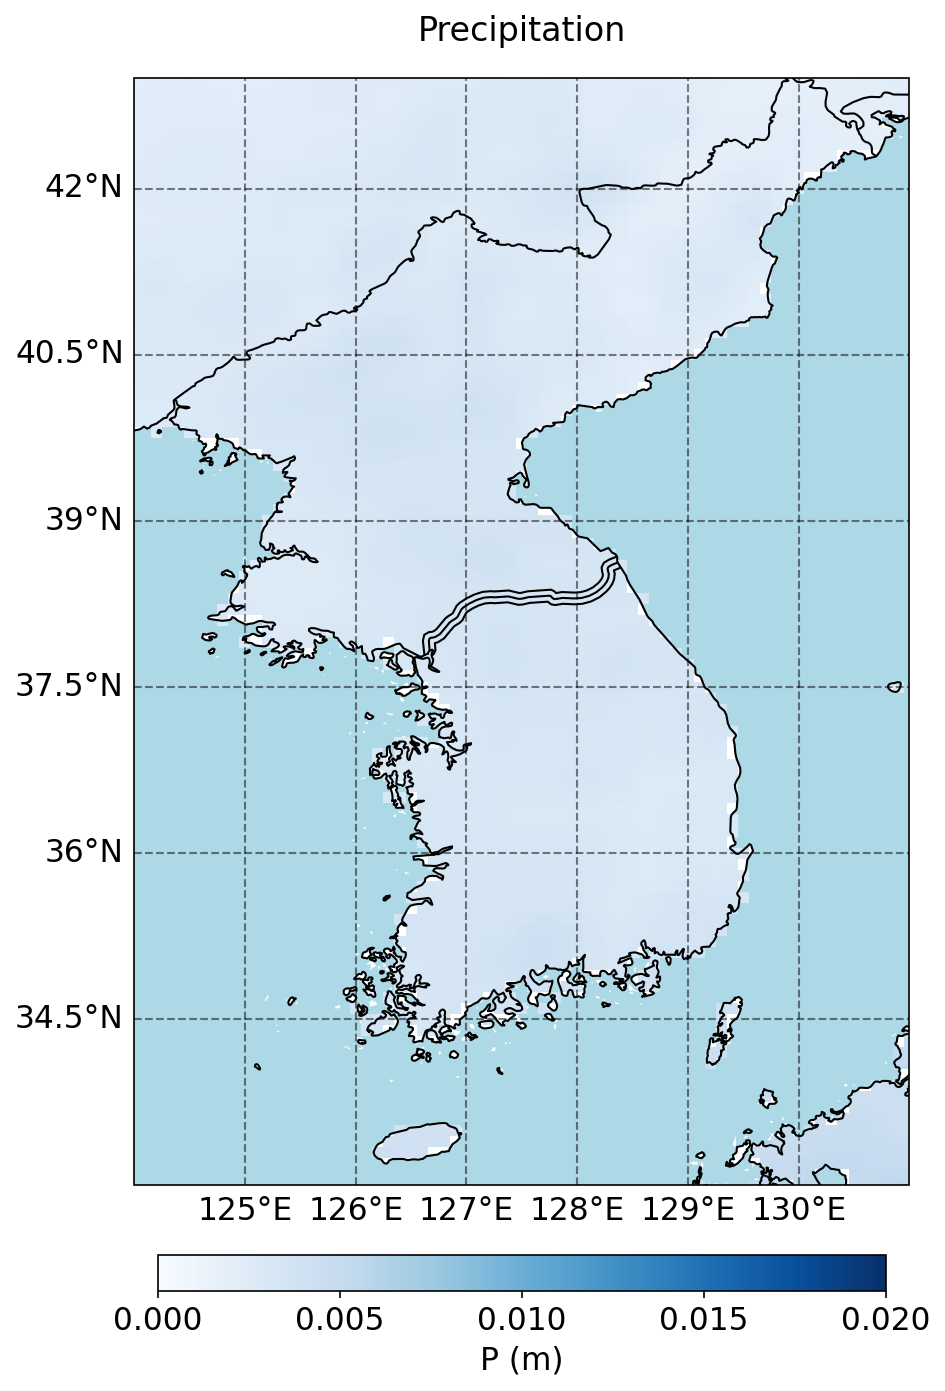

In [3]:
# Loading and Mapping ERA5 data
p    = hData.get_variable_from_nc(ERA5_file_path, 'tp', layer_index='all', flip_data='False')
pev  = hData.get_variable_from_nc(ERA5_file_path, 'pev', layer_index='all', flip_data='False')
p    = np.transpose(p, (1,2,0))
pev  = np.transpose(pev, (1,2,0))
time_units = units[3]
time = hData.get_variable_from_nc(ERA5_file_path, 'time', layer_index='all', flip_data='False')
time = num2date(time, units=time_units, calendar='gregorian')
# Convert to standard datetime objects
time = np.array([datetime.datetime(t.year, t.month, t.day, t.hour, t.minute, t.second) for t in time])

lat  = hData.get_variable_from_nc(ERA5_file_path, 'latitude', layer_index=0)
lon  = hData.get_variable_from_nc(ERA5_file_path, 'longitude', layer_index=0)
lon, lat = np.meshgrid(lon, lat)

hPlot.plot_map(lon, lat, np.nanmean(p,axis=2), 0, 0.02, plot_title='Precipitation', label_title='P (m)', cmap='Blues', projection='PlateCarree');

CRS of the input file: EPSG:3857


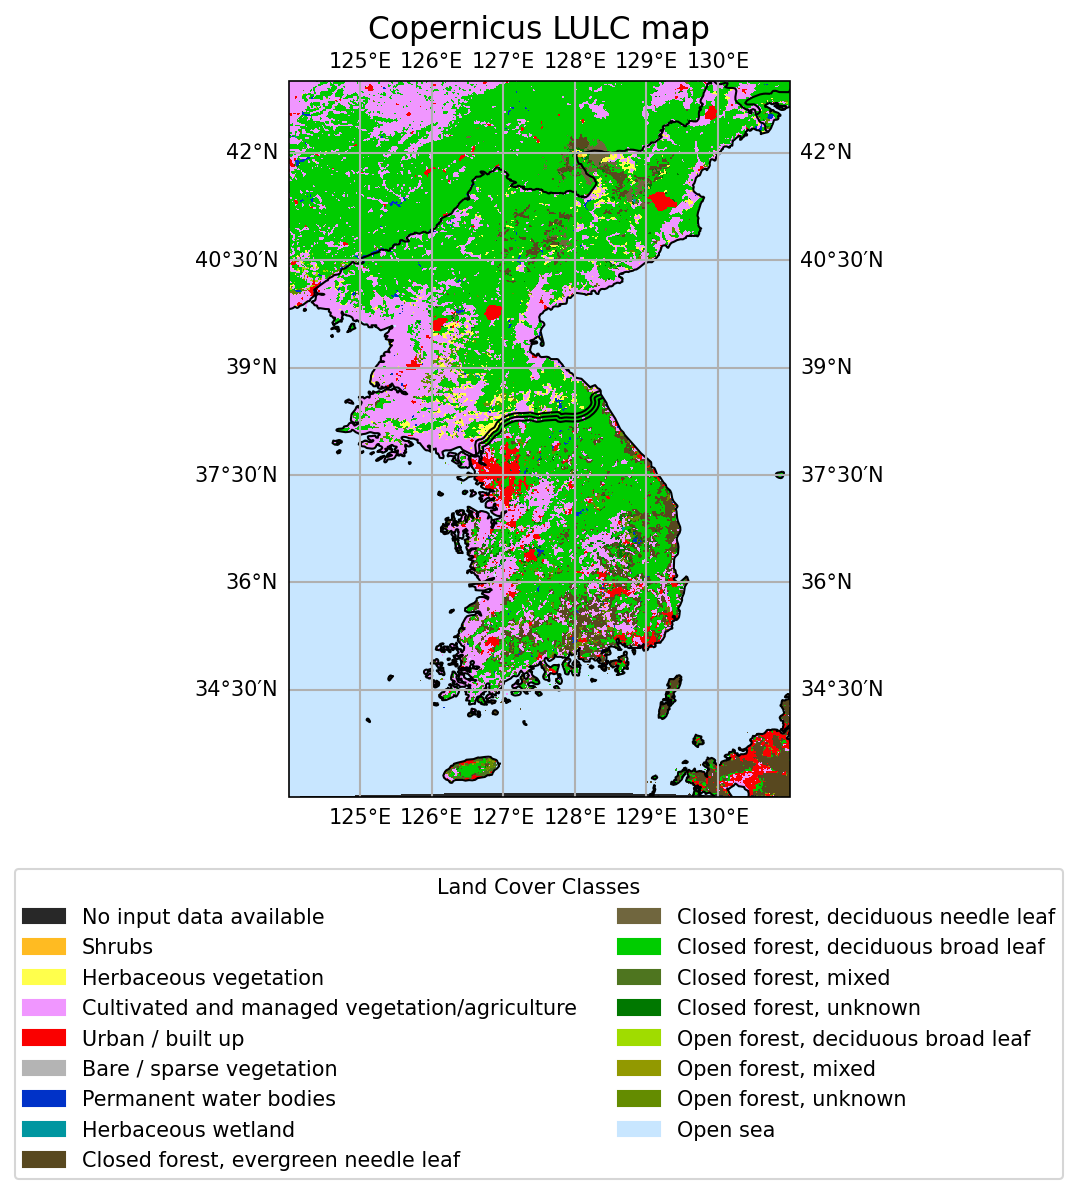

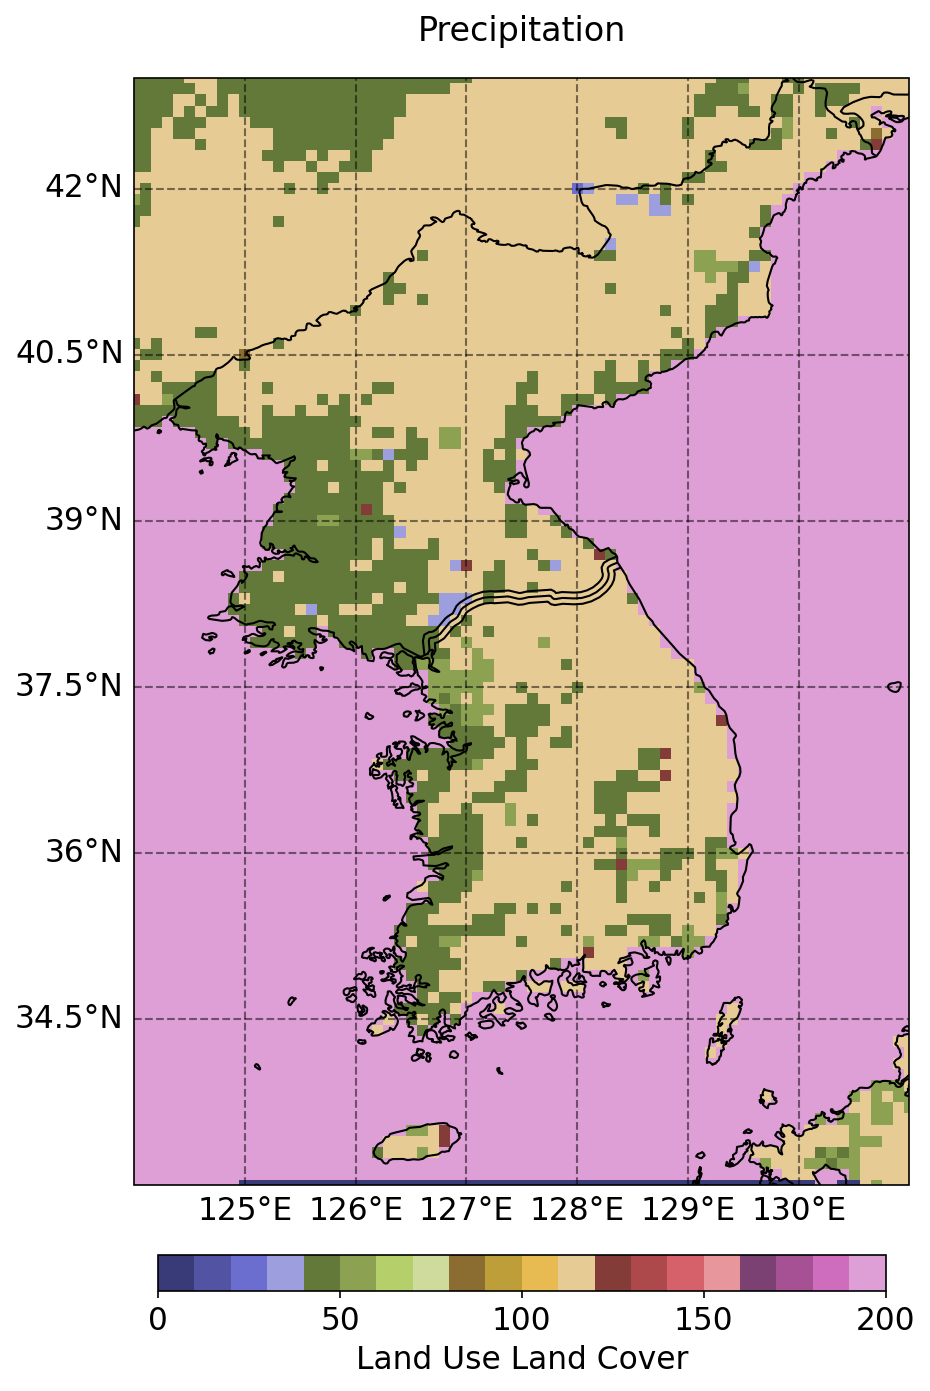

In [4]:
# Loading and Mapping land cover data
#0: 'No input data available',
#111: 'Closed forest, evergreen needle leaf',
#112: 'Closed forest, evergreen, broad leaf',
#113: 'Closed forest, deciduous needle leaf',
#114: 'Closed forest, deciduous broad leaf',
#115: 'Closed forest, mixed',
#116: 'Closed forest, unknown',
#121: 'Open forest, evergreen needle leaf',
#122: 'Open forest, evergreen broad leaf',
#123: 'Open forest, deciduous needle leaf',
#124: 'Open forest, deciduous broad leaf',
#125: 'Open forest, mixed',
#126: 'Open forest, unknown',
#20: 'Shrubs',
#30: 'Herbaceous vegetation',
#40: 'Cultivated and managed vegetation/agriculture',
#50: 'Urban / built up',
#60: 'Bare / sparse vegetation',
#70: 'Snow and Ice',
#80: 'Permanent water bodies',
#90: 'Herbaceous wetland',
#100: 'Moss and lichen',
#200: 'Open sea',
        
LULC_nc_file_name = 'KoreaLandCover2019.tif'
LULC_FP = os.path.join(cpuserver_data_FP,'LULC/copernicus') 
dst_crs = 'EPSG:4326' #https://epsg.io/4326 => lat/lon projection
resolution = 0.01 #for EPSG:4326, 0.03 is around 3-km x 3-km size pixel
land_cover_types, lon_LULC, lat_LULC = hLULC.copernicus(LULC_FP, LULC_nc_file_name, dst_crs, resolution)

bound = [np.min(lon), np.max(lon), np.min(lat), np.max(lat)] # entire Korea
hPlot.plot_LULC_map_copernicus(lon_LULC, lat_LULC, land_cover_types, 'Copernicus LULC map', region=bound)

LULC_or = np.squeeze(land_cover_types.values)
LULC = hData.Resampling(lon, lat, lon_LULC, lat_LULC, LULC_or, 'nearest', agg_method='mode', mag_factor=1)
hPlot.plot_map(lon, lat, LULC, 0, 200, plot_title='Precipitation', label_title='Land Use Land Cover', cmap='tab20b', projection='PlateCarree');

In [6]:
# the lon/lat of SL and PN
SL_lon_lat = [126.9918, 37.5519]
PN_lon_lat = [125.7625, 39.0392]
SL_lon_idx, SL_lat_idx = hData.find_closest_index(lon, lat, SL_lon_lat)
PN_lon_idx, PN_lat_idx = hData.find_closest_index(lon, lat, PN_lon_lat)

In [7]:
# extract data over SL and PN
p_TS_SL = p[SL_lon_idx, SL_lat_idx, :] 
p_TS_PN = p[PN_lon_idx, PN_lat_idx, :] 
pev_TS_SL = pev[SL_lon_idx, SL_lat_idx, :] 
pev_TS_PN = pev[PN_lon_idx, PN_lat_idx, :] 

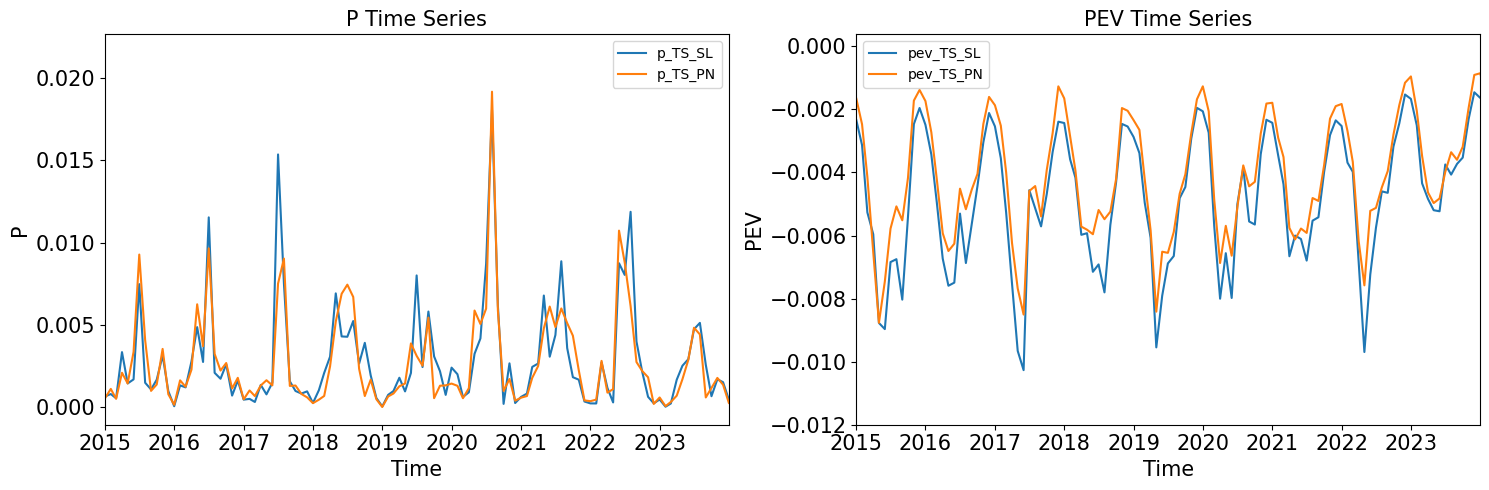

In [8]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

year_1 = 2015
year_2 = 2023

# Plot p_TS_SL and p_TS_PN on the left subplot (ax1)
ax1.plot(time, p_TS_SL, label='p_TS_SL')
ax1.plot(time, p_TS_PN, label='p_TS_PN')
ax1.set_xlabel('Time')
ax1.set_ylabel('P')
ax1.set_title('P Time Series')
ax1.legend()
ax1.set_xlim(datetime.datetime(year_1, 1, 1), datetime.datetime(year_2, 12, 31))

# Plot pev_TS_SL and pev_TS_PN on the right subplot (ax2)
ax2.plot(time, pev_TS_SL, label='pev_TS_SL')
ax2.plot(time, pev_TS_PN, label='pev_TS_PN')
ax2.set_xlabel('Time')
ax2.set_ylabel('PEV')
ax2.set_title('PEV Time Series')
ax2.legend()
ax2.set_xlim(datetime.datetime(year_1, 1, 1), datetime.datetime(year_2, 12, 31))

# Adjust layout
plt.tight_layout()
plt.show()

In [9]:
def calculate_spei(precipitation, evapotranspiration, time_index, scale):
    """
    Calculate the Standardized Precipitation Evapotranspiration Index (SPEI).
    
    Args:
    - precipitation: Pandas Series of precipitation values.
    - evapotranspiration: Pandas Series of evapotranspiration values.
    - time_index: Pandas DatetimeIndex corresponding to the time series.
    - scale: Integer representing the accumulation scale (e.g., 3 for 3 months).

    Returns:
    - spei: Pandas Series of SPEI values with the corresponding time index.
    """
    def calculate_cwb(precipitation, evapotranspiration):
        return precipitation - evapotranspiration

    def accumulate_cwb(cwb, scale):
        # Rolling sum for the specified scale (e.g., 3-month, 6-month)
        return cwb.rolling(window=scale).sum()

    def fit_distribution(cwb_accumulated):
        # Fit a generalized extreme value distribution to the accumulated CWB
        params = genextreme.fit(cwb_accumulated.dropna())
        return params

    def calculate_spei(cwb_accumulated, params):
        # Standardize the accumulated CWB using the fitted distribution
        cdf = genextreme.cdf(cwb_accumulated.dropna(), *params)
        spei = norm.ppf(cdf)
        return spei

    # Calculate CWB
    cwb = calculate_cwb(precipitation, evapotranspiration)

    # Accumulate CWB over the specified scale
    cwb_accumulated = accumulate_cwb(cwb, scale)

    # Fit distribution to the accumulated CWB
    params = fit_distribution(cwb_accumulated)

    # Calculate SPEI
    spei_values = calculate_spei(cwb_accumulated, params)

    # Align the SPEI values with the corresponding time index
    spei = pd.Series(np.nan, index=time_index)  # Initialize with NaNs
    spei[cwb_accumulated.dropna().index] = spei_values  # Assign SPEI values

    return spei

In [10]:
P = pd.Series(p_TS_SL, index=time)
PEV = pd.Series(pev_TS_SL, index=time)
# Calculate SPEI
scale = 6
SPEI = calculate_spei(P, PEV, time, scale)

#P = pd.Series(p_TS_PN, index=time)
#PEV = pd.Series(pev_TS_PN, index=time)
## Calculate SPEI
#scale = 6
#SPEI = calculate_spei(P, PEV, time, scale)

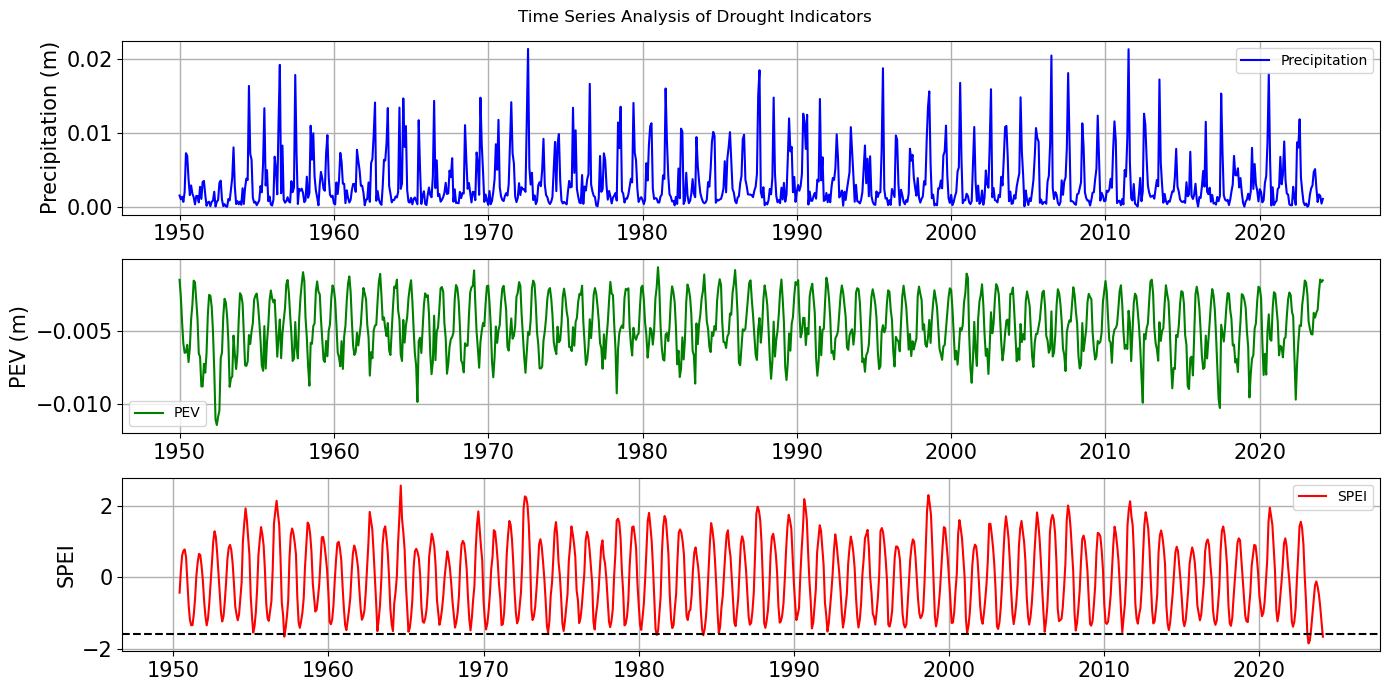

In [11]:
plt.figure(figsize=(14, 7))

# Plot Precipitation
plt.subplot(3, 1, 1)
plt.plot(P.index, P, label='Precipitation', color='blue')
plt.ylabel('Precipitation (m)')
plt.legend()
plt.grid(True)

# Plot Potential Evapotranspiration
plt.subplot(3, 1, 2)
plt.plot(PEV.index, PEV, label='PEV', color='green')
plt.ylabel('PEV (m)')
plt.legend()
plt.grid(True)

th = -1.6
# Plot SPEI
plt.subplot(3, 1, 3)
plt.plot(time, SPEI, label='SPEI', color='red')
plt.axhline(th, color='black', linestyle='--')
plt.fill_between(SPEI.index, SPEI, th, where=(SPEI < th), color='red', alpha=0.3)
plt.ylabel('SPEI')
plt.legend()
plt.grid(True)

plt.suptitle('Time Series Analysis of Drought Indicators')
plt.tight_layout()
plt.show()

In [12]:
# To determine whether the SPEI (Standardized Precipitation Evapotranspiration Index) data significantly differs 
# between the periods 1950-2018 and 2019-2023, you can perform a statistical comparison between these 
# two time periods. 
# Split the data into two periods
spei_1950_2018 = SPEI['1950-01-01':'2018-12-31']
spei_2019_2023 = SPEI['2019-01-01':'2023-12-31']

# Perform the Mann-Kendall test on both periods
result_1950_2018 = mk.original_test(spei_1950_2018)
result_2019_2023 = mk.original_test(spei_2019_2023)

# Print the results of the Mann-Kendall test
print("1950-2018 Mann-Kendall Test Result:", result_1950_2018)
print("2019-2023 Mann-Kendall Test Result:", result_2019_2023)

# Perform a t-test to compare the means of the two periods
t_test_result = ttest_ind(spei_1950_2018, spei_2019_2023, nan_policy='omit')
print("T-test Result:", t_test_result)

# Perform a Mann-Whitney U test to compare the distributions of the two periods
mannwhitney_result = mannwhitneyu(spei_1950_2018, spei_2019_2023, alternative='two-sided')
print("Mann-Whitney U Test Result:", mannwhitney_result)

1950-2018 Mann-Kendall Test Result: Mann_Kendall_Test(trend='no trend', h=False, p=0.605557130790543, z=0.5164256844637783, Tau=0.012029457240586188, s=4069.0, var_s=62050633.666666664, slope=7.244207654049556e-05, intercept=-0.03839945120281594)
2019-2023 Mann-Kendall Test Result: Mann_Kendall_Test(trend='no trend', h=False, p=0.4034314217877122, z=-0.8355085734276976, Tau=-0.07457627118644068, s=-132.0, var_s=24583.333333333332, slope=-0.0061231570079341765, intercept=-0.05643068119700423)
T-test Result: TtestResult(statistic=1.2272797863724954, pvalue=0.22004529117697094, df=881.0)
Mann-Whitney U Test Result: MannwhitneyuResult(statistic=nan, pvalue=nan)


In [13]:
# Urban(50) vs Cultivated and managed vegetation/agriculture(40)
urban_idx = np.argwhere(LULC==50)
agr_idx   = np.argwhere(LULC==40)

In [14]:
# extract data over SL and PN
i, j = urban_idx[0]
ii, jj = agr_idx[100]
p_TS_urban = p[i,j,:]
p_TS_agr = p[ii, jj, :] 
pev_TS_urban = pev[i, j, :] 
pev_TS_agr = pev[ii,jj, :] 

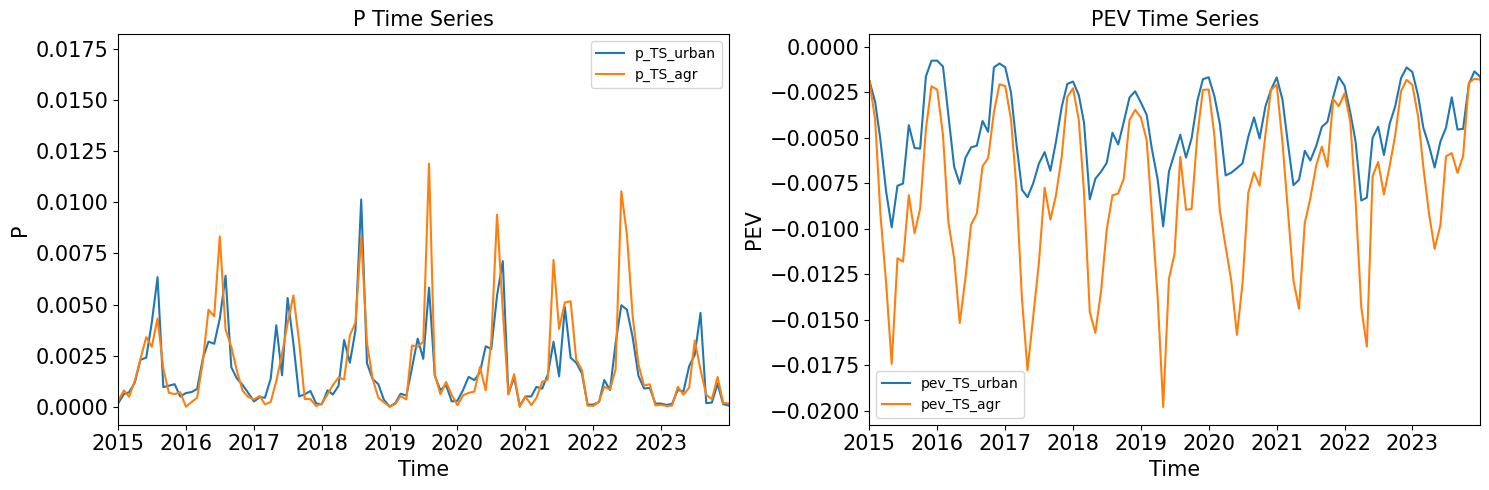

In [15]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

year_1 = 2015
year_2 = 2023

# Plot p_TS_SL and p_TS_PN on the left subplot (ax1)
ax1.plot(time, p_TS_urban, label='p_TS_urban')
ax1.plot(time, p_TS_agr, label='p_TS_agr')
ax1.set_xlabel('Time')
ax1.set_ylabel('P')
ax1.set_title('P Time Series')
ax1.legend()
ax1.set_xlim(datetime.datetime(year_1, 1, 1), datetime.datetime(year_2, 12, 31))

# Plot pev_TS_SL and pev_TS_PN on the right subplot (ax2)
ax2.plot(time, pev_TS_urban, label='pev_TS_urban')
ax2.plot(time, pev_TS_agr, label='pev_TS_agr')
ax2.set_xlabel('Time')
ax2.set_ylabel('PEV')
ax2.set_title('PEV Time Series')
ax2.legend()
ax2.set_xlim(datetime.datetime(year_1, 1, 1), datetime.datetime(year_2, 12, 31))

# Adjust layout
plt.tight_layout()
plt.show()